**Note**; This notebook might take some time to run since it uses the entire data downloaded for BRON. (There is a tutorial that deals with only a subset of the data in `bron_tutorial`)

# Set working directory

In [1]:
import os
cwd = os.path.split(os.getcwd())
if cwd[-1] == 'tutorials':
    os.chdir('..')
!python --version

Python 3.8.2


# Import modules

In [2]:
import json

from BRON.build_BRON import build_graph, BRON_PATH
from path_search.path_search_BRON import main_attack
from meta_analysis.make_data_summary import load_graph_network, main_data_summary
from utils.bron_network_utils import load_graph_nodes
from meta_analysis.meta_analysis_scripts.vendor_tactic_and_cvss import bron_id_to_cpe_id, cve_to_risk, make_heat_map
from utils.tutorial_util import print_files_in_folder

# Build BRON

In [12]:
# Path to save BRON output
save_path = 'full_data/full_output_data'
os.makedirs(save_path, exist_ok=True)
# Path to the downloaded threat information
input_data_folder = 'download_threat_information'
BRON_original_id_to_bron_id_path = os.path.join(save_path, BRON_PATH)

In [4]:
build_graph(save_path, input_data_folder)

In [13]:
print_files_in_folder(BRON_original_id_to_bron_id_path)

cve_id_bron_id.json (modified: Tue Sep 29 09:56:39 2020)
capec_id_to_bron_id.json (modified: Tue Sep 29 09:56:24 2020)
technique_id_to_bron_id.json (modified: Tue Sep 29 09:56:24 2020)
cwe_id_to_bron_id.json (modified: Tue Sep 29 09:56:38 2020)
tactic_name_to_bron_id.json (modified: Tue Sep 29 09:56:24 2020)
cpe_id_bron_id.json (modified: Tue Sep 29 09:56:39 2020)


# Structure of BRON

Each entry of threat data is a node in BRON that has 4 attributes. The node has a unique name in BRON of the form (threat data type)\_(unique 5 digit id) where the threat data type is either Tactic, Technique, CAPEC, CWE, CVE, or CPE.

There are 4 attributes for each node:
- Original_id: ID of threat data in MITRE/NIST if it exists
- Datatype: One of Tactic, Technique, CAPEC, CWE, CVE, or CPE
- Name: Name of threat data in MITRE/NIST if it exists
- Metadata: Any additional information that is contained in MITRE/NIST 

# Find paths in BRON

In [6]:
starting_point_type = 'tactic'
starting_point = f'example_data/example_input_data/starting_point_{starting_point_type}.csv'
results_file = os.path.join(save_path, f'search_result_{starting_point_type}.csv')
length = True
main_attack(BRON_folder_path=save_path,
            args_file=starting_point,
            results_name=results_file,
            arg_type=starting_point_type,
            length=length)

,tactic,technique,capec,cwe,cve,risk_score,cpe,attack,Node Type
0,{tactic_00065},96,15,15,2066,12441.70,10197,NaN,connected
1,{tactic_00023},35,14,4,6499,31446.65,29339,NaN,connected
2,{tactic_00021},137,21,35,17123,100246.55,70846,NaN,connected
3,12,568,581,370,150535,903871.15,219038,0.0,Total Number


In [7]:
length = False
main_attack(BRON_folder_path=save_path,
            args_file=starting_point,
            results_name=results_file,
            arg_type=starting_point_type,
            length=length)

,tactic,technique,capec,cwe,cve,risk_score,cpe,attack,Node Type
0,{tactic_00065},"{technique_00567, technique_00470, technique_0...","{capec_00613, capec_00612, capec_00615, capec_...","{cwe_01305, cwe_00833, cwe_01100, cwe_00885, c...","{cve_315487, cve_99544, cve_258319, cve_343045...",12441.70,"{cpe_245419, cpe_43937, cpe_188678, cpe_39245,...",NaN,connected
1,{tactic_00023},"{technique_00026, technique_00360, technique_0...","{capec_00598, capec_00627, capec_00643, capec_...","{cwe_00825, cwe_01311, cwe_00654, cwe_00730}","{cve_352668, cve_270323, cve_355969, cve_26934...",31446.65,"{cpe_262589, cpe_230909, cpe_241814, cpe_18626...",NaN,connected
2,{tactic_00021},"{technique_00482, technique_00528, technique_0...","{capec_00652, capec_00624, capec_00604, capec_...","{cwe_00885, cwe_00680, cwe_00774, cwe_00727, c...","{cve_96849, cve_343045, cve_352668, cve_270323...",100246.55,"{cpe_289932, cpe_284019, cpe_262589, cpe_23090...",NaN,connected
3,12,568,581,370,150535,903871.15,219038,0.0,Total Number


In [8]:
starting_point_type = 'technique'
starting_point = f'example_data/example_input_data/starting_point_{starting_point_type}.csv'
results_file = os.path.join(save_path, f'search_result_{starting_point_type}.csv')
length = False
main_attack(BRON_folder_path=save_path,
            args_file=starting_point,
            results_name=results_file,
            arg_type=starting_point_type,
            length=length)

,tactic,technique,capec,cwe,cve,risk_score,cpe,attack,Node Type
0,{},{technique_00006},{},{},{},0.00,{},NaN,connected
1,12,568,581,370,150535,903871.15,219038,0.0,Total Number


In [10]:
# Path to BRON data
BRON_path = os.path.join(save_path, 'BRON.json')
save_folder = os.path.join(save_path, 'all_cves_all_versions')
os.makedirs(save_folder, exist_ok=True)
not_all_cpe_versions = False
# Load the BRON graph
graph = load_graph_network(BRON_path, not_all_cpe_versions)

datatypes = ["tactic", "technique", "capec", "cwe", "cve", "cpe"]
# Summarize data sources in BRON
main_data_summary(graph=graph,
                  save_folder=save_folder,
                  data_types=datatypes)

tactic
technique
capec
cwe
cve
cpe


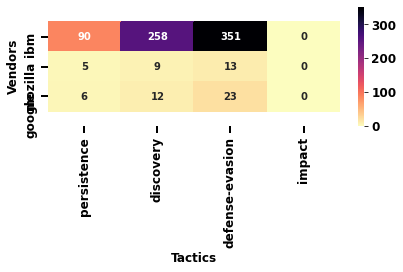

In [14]:
tactics = 'persistence,discovery,defense-evasion,impact'
vendors = 'ibm,mozilla,google'
tactic_search_result_file = os.path.join(save_path, 'search_result_tactic.csv')
plot_type = 'heatmap'
cve_summary_path = os.path.join(save_folder, 'cve_summary.csv')
_save_path = os.path.join(save_path, 'figures')
_figure_path = os.path.join(save_path, 'vendor_tactics.png')
tactics_split = tactics.split(',')
vendors_split = vendors.split(',')
bron_id_to_cpe_id_dict = bron_id_to_cpe_id(save_path)
cve_to_risk_dict = cve_to_risk(cve_summary_path)
with open(os.path.join(BRON_original_id_to_bron_id_path, 'tactic_name_to_bron_id.json'), 'r') as fd:
    all_tactics_name_to_id = json.load(fd)
tactic_ids = [f"tactic_{all_tactics_name_to_id[_]}" for _ in tactics_split]

make_heat_map(tactics_split,
              vendors_split,
              tactic_ids,
              tactic_search_result_file,
              bron_id_to_cpe_id_dict,
              save_path=_figure_path)